In [5]:
# 0) Setup & Load

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.utils import resample

BASE = Path("/Users/kartik/Desktop/aidev-phase2")
OUT = BASE / "outputs"
OUT.mkdir(exist_ok=True, parents=True)

df = pd.read_csv(OUT / "modeling_table_combined.csv", low_memory=False)
print(df.shape)


(939409, 19)


In [29]:
print(f"Total PRs in RQ1 table: {len(df_rq1):,}")

print("\nClass distribution (merged vs closed) from y_rq1:")
print(y_rq1.value_counts(dropna=False))

print("\nClass distribution (merged vs closed) as percentages:")
print((y_rq1.value_counts(normalize=True) * 100).round(2))


Total PRs in RQ1 table: 866,076

Class distribution (merged vs closed) from y_rq1:
y_accept
1    795220
0     70856
Name: count, dtype: int64

Class distribution (merged vs closed) as percentages:
y_accept
1    91.82
0     8.18
Name: proportion, dtype: float64


In [7]:
#1) Feature Matrix (shared for both RQs)

In [8]:
# Basic engineered features
df['title_len'] = df.get('title','').fillna('').astype(str).str.len()
df['body_len']  = df.get('body','').fillna('').astype(str).str.len()
for c in ['loc_added','loc_deleted','files_touched','n_review_comments','stars','forks']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

df['churn_total'] = df['loc_added'] + df['loc_deleted']
df['churn_ratio'] = np.where(df['churn_total']>0, df['loc_deleted']/df['churn_total'], 0.0)

# Simple task flags from title/body (Fix/Feat/Refactor/Unknown)
import re
def task_type(title, body):
    t = (str(title) + " " + str(body)).lower()
    if re.search(r'\b(refactor|cleanup|rename)\b', t): return 'refactor'
    if re.search(r'\b(feat|feature|add|introduce|implement)\b', t): return 'feature'
    if re.search(r'\b(fix|bug|patch|repair|resolve)\b', t): return 'fix'
    return 'unknown'
df['task'] = [task_type(t,b) for t,b in zip(df.get('title',''), df.get('body',''))]

# Final features
NUM_FEATS = ["title_len","body_len","loc_added","loc_deleted","files_touched","churn_total","churn_ratio","stars","forks"]
X_base = df[NUM_FEATS].fillna(0).copy()
X_task = pd.get_dummies(df['task'].fillna('unknown'), prefix='task')
X = pd.concat([X_base, X_task], axis=1)

# Group masks
is_agent = df['contrib_type'].eq('agent')
is_human = df['contrib_type'].eq('human')

# RQ1 label (acceptance); drop open PRs (NaN)
df_rq1 = df[df['y_accept'].isin([0,1])].copy()
X_rq1 = X.loc[df_rq1.index]
y_rq1 = df_rq1['y_accept'].astype(int)

# RQ2 targets
df_rq2_comments = df[df['n_review_comments'].notna()].copy()
X_rq2c = X.loc[df_rq2_comments.index]
y_rq2c = df_rq2_comments['n_review_comments'].astype(float)

df_rq2_ttm = df[df['hours_to_merge'].notna()].copy()
X_rq2t = X.loc[df_rq2_ttm.index]
y_rq2t = df_rq2_ttm['hours_to_merge'].astype(float)

print("RQ1:", X_rq1.shape, y_rq1.shape)
print("RQ2 comments:", X_rq2c.shape, y_rq2c.shape)
print("RQ2 ttm:", X_rq2t.shape, y_rq2t.shape)


RQ1: (866076, 13) (866076,)
RQ2 comments: (939409, 13) (939409,)
RQ2 ttm: (795220, 13) (795220,)


In [9]:
#2) Utility: train/test split + metrics

In [10]:
def split_xy(X, y, test_size=0.3, stratify=True, seed=42):
    return train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y if (stratify and len(np.unique(y))==2) else None)

def cls_report(y_true, y_pred, y_prob=None):
    out = dict(
        acc = accuracy_score(y_true, y_pred),
        f1  = f1_score(y_true, y_pred)
    )
    if y_prob is not None:
        out['auc'] = roc_auc_score(y_true, y_prob)
    return out

def reg_report(y_true, y_pred):
    return dict(
        mae = mean_absolute_error(y_true, y_pred),
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    )


In [11]:
#3) RQ1 — Acceptance (Merged vs Closed)

In [12]:
#3a) Pooled

In [13]:
X_tr, X_te, y_tr, y_te = split_xy(X_rq1, y_rq1)

# Logistic (class_weight helps with imbalance within pooled data)
lr = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None)
lr.fit(X_tr, y_tr)
p_lr = lr.predict(X_te); proba_lr = lr.predict_proba(X_te)[:,1]
pooled_lr = cls_report(y_te, p_lr, proba_lr)

# Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced')
rf.fit(X_tr, y_tr)
p_rf = rf.predict(X_te); proba_rf = rf.predict_proba(X_te)[:,1]
pooled_rf = cls_report(y_te, p_rf, proba_rf)

pooled_rq1 = pd.DataFrame([dict(group='pooled', model='LogReg', **pooled_lr),
                           dict(group='pooled', model='RF', **pooled_rf)])
pooled_rq1


,group,model,acc,f1,auc
0,pooled,LogReg,0.771806,0.866579,0.617020
1,pooled,RF,0.821682,0.900686,0.557339


In [14]:
#3b) Per-group (agent / human)

In [15]:
def run_group_cls(mask):
    idx = df_rq1[mask.loc[df_rq1.index]].index
    if len(idx) < 300: return None  # skip tiny groups
    Xg, yg = X_rq1.loc[idx], y_rq1.loc[idx]
    X_tr, X_te, y_tr, y_te = split_xy(Xg, yg)

    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr.fit(X_tr, y_tr)
    p = lr.predict(X_te); proba = lr.predict_proba(X_te)[:,1]
    row_lr = dict(model='LogReg', **cls_report(y_te, p, proba))

    rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced')
    rf.fit(X_tr, y_tr)
    p = rf.predict(X_te); proba = rf.predict_proba(X_te)[:,1]
    row_rf = dict(model='RF', **cls_report(y_te, p, proba))
    return pd.DataFrame([row_lr, row_rf])

agent_rows = run_group_cls(is_agent)
if agent_rows is not None:
    agent_rows.insert(0, 'group', 'agent')

human_rows = run_group_cls(is_human)
if human_rows is not None:
    human_rows.insert(0, 'group', 'human')

rq1_groups = pd.concat([pooled_rq1, agent_rows, human_rows], ignore_index=True)
rq1_groups.to_csv(OUT/"rq1_metrics_groups.csv", index=False)
rq1_groups


,group,model,acc,f1,auc
0,pooled,LogReg,0.771806,0.866579,0.617020
1,pooled,RF,0.821682,0.900686,0.557339
2,agent,LogReg,0.771423,0.866336,0.617380
3,agent,RF,0.821989,0.900885,0.557868
4,human,LogReg,0.615176,0.735666,0.577230
5,human,RF,0.783740,0.873694,0.588314


In [16]:
#3c) Balanced comparison (downsample agents to human count)

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# ---- 3c) Balanced (downsample agents to human count) — with imputation ----
rq1_df = df_rq1[['contrib_type']].copy()
rq1_df['y'] = y_rq1.values
rq1_df = pd.concat([rq1_df, X_rq1.reset_index(drop=True)], axis=1)

human_subset = rq1_df[rq1_df['contrib_type']=='human']
agent_subset = rq1_df[rq1_df['contrib_type']=='agent']

if len(human_subset) > 300 and len(agent_subset) > 300:
    agent_down = resample(agent_subset, n_samples=len(human_subset), replace=False, random_state=42)
    balanced = pd.concat([human_subset, agent_down], ignore_index=True)

    # Features/labels
    Xb = balanced[X.columns].copy()
    yb = balanced['y'].astype(int)

    # replace inf -> NaN, then impute
    Xb = Xb.replace([np.inf, -np.inf], np.nan)

    # split
    X_tr, X_te, y_tr, y_te = split_xy(Xb, yb)

    # Pipelines with imputer
    lr_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            LogisticRegression(max_iter=1000))
    rf_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            RandomForestClassifier(n_estimators=400, random_state=42))

    # fit/predict
    lr_pipe.fit(X_tr, y_tr)
    p = lr_pipe.predict(X_te); proba = lr_pipe.predict_proba(X_te)[:,1]
    bal_lr = cls_report(y_te, p, proba)

    rf_pipe.fit(X_tr, y_tr)
    p = rf_pipe.predict(X_te); proba = rf_pipe.predict_proba(X_te)[:,1]
    bal_rf = cls_report(y_te, p, proba)

    rq1_bal = pd.DataFrame([
        dict(group='balanced(agent=human)', model='LogReg', **bal_lr),
        dict(group='balanced(agent=human)', model='RF', **bal_rf)
    ])
    rq1_bal.to_csv(OUT/"rq1_metrics_balanced.csv", index=False)
    display(rq1_bal)
else:
    print("Not enough human or agent samples for balanced comparison.")


,group,model,acc,f1,auc
0,balanced(agent=human),LogReg,0.87290,0.932137,0.570903
1,balanced(agent=human),RF,0.86748,0.928955,0.609358


In [18]:
#3d) Feature importance (pooled RF)

In [19]:
rf_full = RandomForestClassifier(n_estimators=600, random_state=42, class_weight='balanced').fit(X_rq1, y_rq1)
imps = pd.Series(rf_full.feature_importances_, index=X_rq1.columns).sort_values(ascending=False).head(20)
imps.to_csv(OUT/"feature_importance_acceptance_top20.csv")
ax = imps.plot(kind='bar', figsize=(10,4)); ax.set_title("Top-20 Feature Importances (Acceptance)")
plt.tight_layout(); plt.savefig(OUT/"feature_importance_acceptance_top20.png", dpi=200)
plt.close()


# Phase 3 Extension – RQ1: Predicting PR Acceptance with Additional Models

This section extends the original RQ1 analysis to address Phase 3 requirements:

- Add more **machine learning models** beyond Logistic Regression and Random Forest.
- Include **baselines** (majority and heuristic rule).
- Use **5-fold stratified cross-validation** with rich metrics.
- Produce a **confusion matrix** and extract **false positives / false negatives** for error analysis.

We reuse the existing feature matrix `X_rq1` and label vector `y_rq1` constructed earlier in the notebook.


In [20]:
# 1) Imports for extended RQ1 modeling (Phase 3)

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("X_rq1 shape:", X_rq1.shape)
print("y_rq1 distribution:", y_rq1.value_counts(normalize=True))

X_rq1 shape: (866076, 13)
y_rq1 distribution: y_accept
1    0.918187
0    0.081813
Name: proportion, dtype: float64


## 1. Preprocessing Setup

We treat all existing RQ1 features as numeric (they were already engineered in previous cells).
We apply standardization (`StandardScaler`) before feeding them into models.

If future work introduces categorical features, the pipeline can be extended with one-hot encoding.


In [21]:
# 2) Preprocessor: currently assume all RQ1 features are numeric

numeric_features = X_rq1.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop"
)

print("Number of numeric features used for RQ1:", len(numeric_features))

Number of numeric features used for RQ1: 13


## 2. Baselines

We define two baselines to contextualize model performance:

1. **Majority classifier** – always predicts the most frequent class in the training data.
2. **Heuristic classifier** – predicts *merged* when the PR body is long and the number of files touched is small.

The heuristic mirrors the intuition that *clearer, focused PRs* are more likely to be accepted.


In [22]:
# 3) Baseline definitions

# Columns used by the heuristic. Adjust if your table uses different names.
BODY_LEN_COL = 'body_len'       # created earlier in the notebook
FILES_TOUCHED_COL = 'files_touched'  # numeric diff feature

def majority_baseline_cv(y, cv_splits):
    """Cross-validated majority baseline for RQ1."""
    accs, f1s, aucs, precs, recs = [], [], [], [], []
    y = y.astype(int)

    for train_idx, test_idx in cv_splits:
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        majority_class = y_train.value_counts().idxmax()
        y_pred = np.full_like(y_test, fill_value=majority_class)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        aucs.append(0.5)  # constant classifier

    return {
        "Accuracy": float(np.mean(accs)),
        "F1": float(np.mean(f1s)),
        "Precision": float(np.mean(precs)),
        "Recall": float(np.mean(recs)),
        "AUC": float(np.mean(aucs)),
    }


def heuristic_baseline_cv(X, y, cv_splits,
                          body_col=BODY_LEN_COL,
                          files_col=FILES_TOUCHED_COL):
    """Cross-validated heuristic baseline.

    Rule:
      if body_len > T and files_touched <= K -> predict 1 (merged)
      else -> predict 0 (closed)

    T and K are tuned on the training split via a small grid search.
    """
    accs, f1s, aucs, precs, recs = [], [], [], [], []
    y = y.astype(int)

    # Defensive: if required columns are missing, fall back to majority
    if body_col not in X.columns or files_col not in X.columns:
        print("[WARN] Heuristic columns missing; falling back to majority behavior.")
        return majority_baseline_cv(y, cv_splits)

    body_vals = X[body_col].astype(float)
    files_vals = X[files_col].astype(float)

    # Candidate thresholds: quantiles in the full dataset
    body_thresholds = np.quantile(body_vals, [0.3, 0.5, 0.7])
    files_thresholds = np.quantile(files_vals, [0.3, 0.5, 0.7])

    for train_idx, test_idx in cv_splits:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_f1 = -1.0
        best_T, best_K = None, None

        # Grid search thresholds on train
        for T in body_thresholds:
            for K in files_thresholds:
                y_train_pred = ((X_train[body_col] > T) & (X_train[files_col] <= K)).astype(int)
                f1 = f1_score(y_train, y_train_pred, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_T, best_K = T, K

        # Evaluate on test
        y_test_pred = ((X_test[body_col] > best_T) & (X_test[files_col] <= best_K)).astype(int)

        accs.append(accuracy_score(y_test, y_test_pred))
        f1s.append(f1_score(y_test, y_test_pred, zero_division=0))
        precs.append(precision_score(y_test, y_test_pred, zero_division=0))
        recs.append(recall_score(y_test, y_test_pred, zero_division=0))
        aucs.append(0.5)  # not a probabilistic model

    return {
        "Accuracy": float(np.mean(accs)),
        "F1": float(np.mean(f1s)),
        "Precision": float(np.mean(precs)),
        "Recall": float(np.mean(recs)),
        "AUC": float(np.mean(aucs)),
    }

## 3. Extended Model Family (5 Classifiers)

We evaluate five supervised classifiers for RQ1:

1. **Logistic Regression (LR)** – linear, interpretable baseline.
2. **Random Forest (RF)** – bagging-based tree ensemble.
3. **Gradient Boosting Classifier (GBC)** – boosting-based ensemble.
4. **Extra Trees Classifier (ET)** – extremely randomized trees.
5. **Multi-Layer Perceptron (MLP)** – simple neural network over tabular features.

All models share the same preprocessed features and cross-validation splits.


In [23]:
# 4) Classifier definitions

classifiers_rq1 = {
    "logreg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "rf": RandomForestClassifier(
        n_estimators=400,
        max_depth=16,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "gbc": GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    ),
    "et": ExtraTreesClassifier(
        n_estimators=400,
        max_depth=16,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "mlp": MLPClassifier(
        hidden_layer_sizes=(128,),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        random_state=RANDOM_STATE
    ),
}

list(classifiers_rq1.keys())

['logreg', 'rf', 'gbc', 'et', 'mlp']

## 4. Cross-Validation and Metrics

We run **5-fold stratified cross-validation** on `X_rq1`, `y_rq1` and compute:

- Accuracy
- Precision
- Recall
- F1
- ROC–AUC

We evaluate:
- Majority baseline
- Heuristic baseline
- All five classifiers


In [24]:
# 5) Cross-validation evaluation for RQ1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
splits_rq1 = list(skf.split(X_rq1, y_rq1))

results_rq1 = {}

print("Evaluating majority baseline...")
results_rq1["majority"] = majority_baseline_cv(y_rq1, splits_rq1)

print("Evaluating heuristic baseline...")
results_rq1["heuristic"] = heuristic_baseline_cv(X_rq1, y_rq1, splits_rq1)

# Evaluate all classifiers
for name, clf in classifiers_rq1.items():
    print(f"\nEvaluating model: {name}")
    accs, f1s, aucs, precs, recs = [], [], [], [], []

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", clf),
        ]
    )

    for train_idx, test_idx in splits_rq1:
        X_train, X_test = X_rq1.iloc[train_idx], X_rq1.iloc[test_idx]
        y_train, y_test = y_rq1.iloc[train_idx], y_rq1.iloc[test_idx]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        model_ = pipe.named_steps["model"]
        # probability / score for AUC
        if hasattr(model_, "predict_proba"):
            y_prob = model_.predict_proba(preprocessor.transform(X_test))[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        elif hasattr(model_, "decision_function"):
            scores = model_.decision_function(preprocessor.transform(X_test))
            auc = roc_auc_score(y_test, scores)
        else:
            auc = 0.5

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        precs.append(precision_score(y_test, y_pred, zero_division=0))
        recs.append(recall_score(y_test, y_pred, zero_division=0))
        aucs.append(auc)

    results_rq1[name] = {
        "Accuracy": float(np.mean(accs)),
        "F1": float(np.mean(f1s)),
        "Precision": float(np.mean(precs)),
        "Recall": float(np.mean(recs)),
        "AUC": float(np.mean(aucs)),
    }

df_rq1_results = pd.DataFrame(results_rq1).T[
    ["Accuracy", "F1", "Precision", "Recall", "AUC"]
].sort_values("F1", ascending=False)

df_rq1_results_rounded = df_rq1_results.round(3)
df_rq1_results_rounded

Evaluating majority baseline...
Evaluating heuristic baseline...

Evaluating model: logreg

Evaluating model: rf

Evaluating model: gbc

Evaluating model: et

Evaluating model: mlp


,Accuracy,F1,Precision,Recall,AUC
rf,0.920,0.958,0.921,0.998,0.676
gbc,0.919,0.958,0.920,0.998,0.675
et,0.919,0.958,0.919,1.000,0.652
mlp,0.919,0.957,0.919,0.999,0.652
majority,0.918,0.957,0.918,1.000,0.500
logreg,0.772,0.866,0.936,0.807,0.617
heuristic,0.650,0.783,0.908,0.689,0.500


## 5. Confusion Matrix and Error Analysis (Best Model)

We now:

1. Select the **best model** by F1.
2. Train it on an 80/20 train-test split.
3. Plot the **confusion matrix**.
4. Extract **false positives (FP)** and **false negatives (FN)** for qualitative inspection.


In [25]:
# 6) Confusion matrix and FP/FN examples

# Pick best model by F1
best_model_name = df_rq1_results['F1'].idxmax()
print("Best model for RQ1 (by F1):", best_model_name)

best_clf = classifiers_rq1[best_model_name]

X_tr, X_te, y_tr, y_te = train_test_split(
    X_rq1, y_rq1,
    test_size=0.2,
    stratify=y_rq1,
    random_state=RANDOM_STATE
)

pipe_best = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_clf),
    ]
)

pipe_best.fit(X_tr, y_tr)
y_pred = pipe_best.predict(X_te)

cm = confusion_matrix(y_te, y_pred)
cm

Best model for RQ1 (by F1): rf


array([[   591,  13580],
       [   314, 158731]])

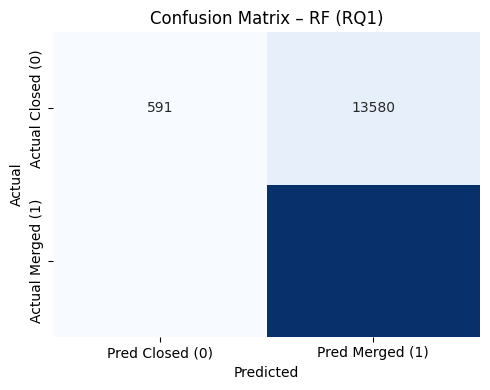

In [26]:
# Plot confusion matrix

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred Closed (0)", "Pred Merged (1)"],
    yticklabels=["Actual Closed (0)", "Actual Merged (1)"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix – {best_model_name.upper()} (RQ1)")
plt.tight_layout()
plt.show()

In [27]:
# Extract FP / FN indexes for qualitative inspection

test_idx = y_te.index
results_test = pd.DataFrame({
    "true_label": y_te,
    "pred_label": y_pred
}, index=test_idx)

# Optionally bring in helpful context columns if present
cols_for_inspection = []
for c in ["pr_id", "title", "body_len", "files_touched", "loc_added", "loc_deleted"]:
    if c in df_rq1.columns:
        cols_for_inspection.append(c)

if cols_for_inspection:
    results_test = results_test.join(df_rq1[cols_for_inspection])

fp_df = results_test[(results_test["true_label"] == 0) & (results_test["pred_label"] == 1)]
fn_df = results_test[(results_test["true_label"] == 1) & (results_test["pred_label"] == 0)]

print("False Positives (pred=merged, actual=closed):", fp_df.shape[0])
display(fp_df.head())

print("\nFalse Negatives (pred=closed, actual=merged):", fn_df.shape[0])
display(fn_df.head())

False Positives (pred=merged, actual=closed): 13580


,true_label,pred_label,pr_id,title,body_len,files_touched,loc_added,loc_deleted
835272,0,1,762,Improve drag preview,280,0.0,0.0,0.0
263071,0,1,2,Add placeholder index page for GitHub Pages,103,0.0,0.0,0.0
536498,0,1,2,Add agent workflow and tests,357,0.0,0.0,0.0
921071,0,1,393,Add skeleton loaders and Suspense boundaries t...,2497,0.0,0.0,0.0
161894,0,1,5,Fix packaging error by zipping to a temporary ...,260,0.0,0.0,0.0



False Negatives (pred=closed, actual=merged): 314


,true_label,pred_label,pr_id,title,body_len,files_touched,loc_added,loc_deleted
911324,1,0,21911,feat: disable changing field type of routing f...,3441,0.0,0.0,0.0
52210,1,0,3,[WIP] # Projeto Refatorado: Sistema de Gestão ...,6901,0.0,0.0,0.0
912673,1,0,848,Fix: Add use_tools flag to chatConfig in creat...,608,0.0,0.0,0.0
1311,1,0,100,Merge bitcoin/bitcoin#24851: init: ignore BIP-...,1073,0.0,0.0,0.0
28104,1,0,6206,Mark `sx` prop as deprecated in *.docs.json files,1800,0.0,0.0,0.0
